# Работаем с opendap из Python

### что такое opendap читаем например [здесь](https://www.opendap.org)

In [1]:
%matplotlib inline

Загружаем стандарую библиотеку визуализации

Я думаю, тут нефиг особо объяснять

In [2]:
import matplotlib.pyplot as plt

Для работы с такими сервисами мне удобно использовать пакет iris.

Его разработали толковые люди из MetOffice (UK).
[Здесь](http://scitools.org.uk) документация к их пакетам. Их 2, второй (cartopy) используетя для визуализации данных с применением картографиxеских проекций

In [3]:
import iris
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

In [4]:
url = 'http://mis.bsmfc.net:8080/thredds/dodsC/dataset-bs-mfc-instan-phys-for-v3'

Это, собственно, ссылка на продукт системы

Загружаем её

In [5]:
odap = iris.load(url)

/opt/miniconda3/envs/ocean/lib/python3.5/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


Вот что там есть

In [6]:
print (odap)

0: eastward_sea_water_velocity / (m s-1) (time: 760; depth: 38; latitude: 132; longitude: 238)
1: northward_sea_water_velocity / (m s-1) (time: 760; depth: 38; latitude: 132; longitude: 238)
2: sea_surface_height_above_sea_level / (meters) (time: 760; latitude: 132; longitude: 238)
3: sea_water_salinity / (1e-3)         (time: 760; depth: 38; latitude: 132; longitude: 238)
4: sea_water_temperature / (K)         (time: 760; depth: 38; latitude: 132; longitude: 238)


По сути, что делает opendap, он говорит, что все файлы netcdf (а именно в таком формате всё там хранится), которые лежат у меня на серваке, это один большой файл

Пишу небольшую функцию, чтоб рисовать карту. Это нужно, чтоб просто красиво представить "цифры", которые я вытащу из opendap'а

In [7]:
LAND = cfeature.NaturalEarthFeature(category='physical', scale='50m', name='land',color = cfeature.COLORS['land'])
def draw_grid(ax, extent = [27.4,42.1, 40.7,46.8]):
    ax.set_extent(extent)
    if isinstance(ax.projection, ccrs.PlateCarree) or isinstance(ax.projection, ccrs.Mercator):
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.,
                          color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    else:
        gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      linewidth=1.5, color='gray', alpha=0.5, linestyle='--')
    return ax

Все переменные в iris представлен кубами (это они так назвали). Куб можно резать, осреднять и т.д.

Беру куб температуры

In [8]:
temp = odap[4]

In [9]:
print (temp)

sea_water_temperature / (K)         (time: 760; depth: 38; latitude: 132; longitude: 238)
     Dimension coordinates:
          time                           x           -             -               -
          depth                          -           x             -               -
          latitude                       -           -             x               -
          longitude                      -           -             -               x
     Attributes:
          Conventions: CF-1.4
          bulletin_date: 2017-07-03
          bulletin_type: forecast
          comment: null
          contact: yubrat@gmail.com
          creation_date: 2017-07-03 UTC
          deepest_depth: 2100.0
          easternmost_longitude: 41.8955
          field_date: 2017-07-06
          field_type: instantaneous
          forecast_range: 4-day analysis, 5-day forecast
          forecast_type: forecast
          grid_resolution: ~5 km (11/180 deg lon, 2/45 deg lat)
          history: YYYY-MM-D

тут куча важной инфы, которкую обычно никто не читает

возмеме только 1-й горизонт

In [10]:
temp = temp[:,0,...]

In [11]:
print (temp)

sea_water_temperature / (K)         (time: 760; latitude: 132; longitude: 238)
     Dimension coordinates:
          time                           x              -               -
          latitude                       -              x               -
          longitude                      -              -               x
     Scalar coordinates:
          depth: 2.5 meters
     Attributes:
          Conventions: CF-1.4
          bulletin_date: 2017-07-03
          bulletin_type: forecast
          comment: null
          contact: yubrat@gmail.com
          creation_date: 2017-07-03 UTC
          deepest_depth: 2100.0
          easternmost_longitude: 41.8955
          field_date: 2017-07-06
          field_type: instantaneous
          forecast_range: 4-day analysis, 5-day forecast
          forecast_type: forecast
          grid_resolution: ~5 km (11/180 deg lon, 2/45 deg lat)
          history: YYYY-MM-DD hh:mm[:ss] MHI RAS Netcdf creation
          institution: MHI RAS
        

Графическая библиотека iris на основе matplotlib

In [12]:
import iris.plot as iplt

/opt/miniconda3/envs/ocean/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/miniconda3/envs/ocean/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


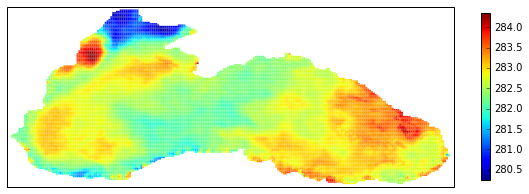

In [13]:
plt.figure(figsize=(10,6))
iplt.pcolor(temp[0])
plt.colorbar(shrink=0.5)

Последние 3 суток это как раз прогноз, нам нужно взять 4 (+сегодня) и поскольку дискретность по времени 3 часа,
то нам нужно 4*8 последних записей

In [14]:
temp = temp[-32:,...]

In [15]:
print (temp)

sea_water_temperature / (K)         (time: 32; latitude: 132; longitude: 238)
     Dimension coordinates:
          time                           x             -               -
          latitude                       -             x               -
          longitude                      -             -               x
     Scalar coordinates:
          depth: 2.5 meters
     Attributes:
          Conventions: CF-1.4
          bulletin_date: 2017-07-03
          bulletin_type: forecast
          comment: null
          contact: yubrat@gmail.com
          creation_date: 2017-07-03 UTC
          deepest_depth: 2100.0
          easternmost_longitude: 41.8955
          field_date: 2017-07-06
          field_type: instantaneous
          forecast_range: 4-day analysis, 5-day forecast
          forecast_type: forecast
          grid_resolution: ~5 km (11/180 deg lon, 2/45 deg lat)
          history: YYYY-MM-DD hh:mm[:ss] MHI RAS Netcdf creation
          institution: MHI RAS
          ne

/opt/miniconda3/envs/ocean/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/miniconda3/envs/ocean/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


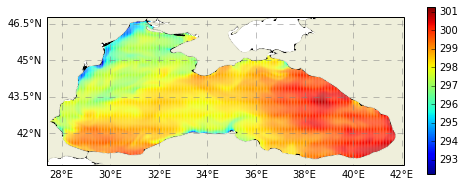

In [16]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
draw_grid(ax)
ax.coastlines('10m')
ax.add_feature(LAND)
iplt.pcolor(temp[0])
plt.colorbar(shrink=0.5)

Можно конвертнуть в градусы Целсия

In [17]:
temp.convert_units('Celsius')

/opt/miniconda3/envs/ocean/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/miniconda3/envs/ocean/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


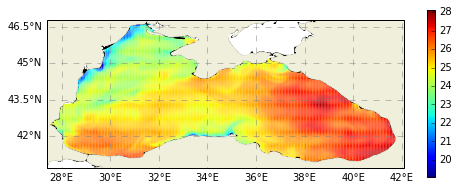

In [18]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
draw_grid(ax)
ax.coastlines('10m')
ax.add_feature(LAND)
iplt.pcolor(temp[0])
plt.colorbar(shrink=0.5)

In [19]:
for c in [temp.coord('latitude'),temp.coord('longitude')]:
        c.guess_bounds()

Даты в кубе

In [20]:
time = temp.coord(axis='T')
time = time.units.num2date(time.points)
time

array([datetime.datetime(2017, 7, 4, 0, 0),
       datetime.datetime(2017, 7, 4, 3, 0),
       datetime.datetime(2017, 7, 4, 6, 0),
       datetime.datetime(2017, 7, 4, 9, 0),
       datetime.datetime(2017, 7, 4, 12, 0),
       datetime.datetime(2017, 7, 4, 15, 0),
       datetime.datetime(2017, 7, 4, 18, 0),
       datetime.datetime(2017, 7, 4, 21, 0),
       datetime.datetime(2017, 7, 5, 0, 0),
       datetime.datetime(2017, 7, 5, 3, 0),
       datetime.datetime(2017, 7, 5, 6, 0),
       datetime.datetime(2017, 7, 5, 9, 0),
       datetime.datetime(2017, 7, 5, 12, 0),
       datetime.datetime(2017, 7, 5, 15, 0),
       datetime.datetime(2017, 7, 5, 18, 0),
       datetime.datetime(2017, 7, 5, 21, 0),
       datetime.datetime(2017, 7, 6, 0, 0),
       datetime.datetime(2017, 7, 6, 3, 0),
       datetime.datetime(2017, 7, 6, 6, 0),
       datetime.datetime(2017, 7, 6, 9, 0),
       datetime.datetime(2017, 7, 6, 12, 0),
       datetime.datetime(2017, 7, 6, 15, 0),
       datetime.dateti

In [21]:
plt.style.use('ggplot')

In [22]:
stations = [[ 34.01, 44.39], [ 33.594,  44.4844], [33.52393,  44.6451]]
stnames = ['Simeiz','Balaklava','Lubimovka']

Вырежем данные для района Симеиза

In [23]:
const = iris.Constraint(longitude=stations[0][0],latitude=stations[0][1])

In [24]:
sttemp = temp.extract(const)

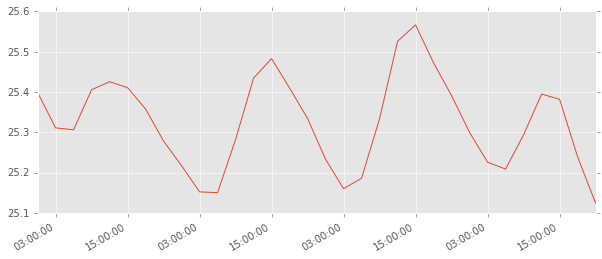

In [25]:
plt.figure(figsize=(10,4))
iplt.plot(sttemp)
plt.gcf().autofmt_xdate()

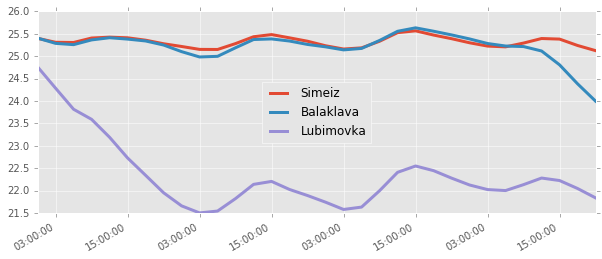

In [27]:
plt.figure(figsize=(10,4))
for st,name in zip(stations,stnames):
    const = iris.Constraint(longitude=st[0],latitude=st[1])
    sttemp = temp.extract(const)
    iplt.plot(sttemp,label=name,lw=3)
plt.gcf().autofmt_xdate()
plt.legend(loc='best')

А в Любимовке действительно холодает водичка :)